In [350]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime

import random

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [351]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:

# https://www.tensorflow.org/api_docs/python/tf/random/set_seed

tf.random.set_seed(1234)

In [352]:
# Clear any logs from previous runs
# rm -rf ./data/logs/

In [353]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [354]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4000 files belonging to 4 classes.


In [355]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [356]:
# len(dataset)

In [357]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Test",
    seed = 123,
    shuffle = False,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [358]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [359]:
# len(testset)

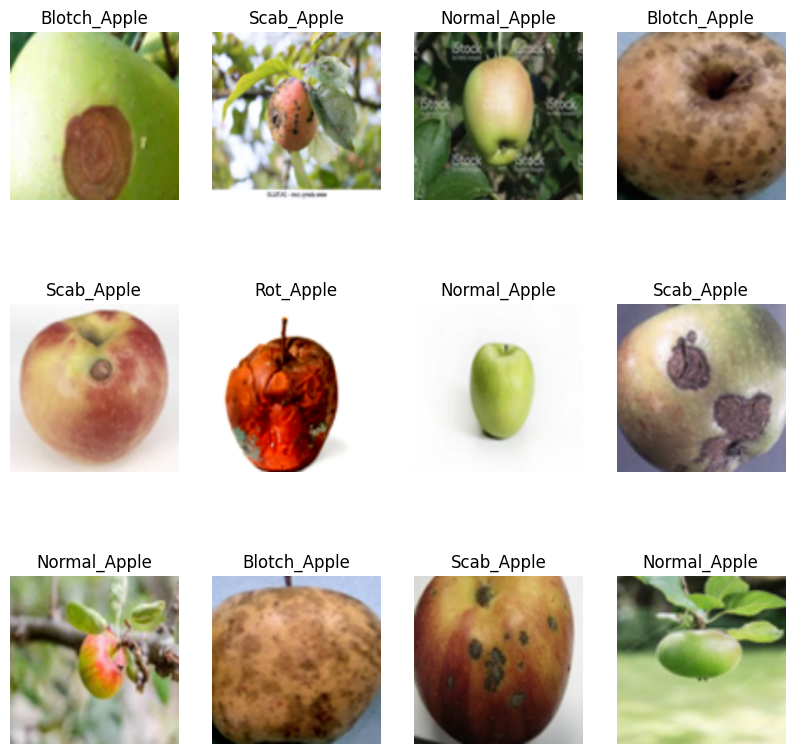

In [360]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[0].numpy)
    # print(image_batch[0].shape)
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        # plt.imshow(image_batch[0].numpy().astype("uint8"))
        # plt.title(class_names[label_batch[0]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] ipv [0] wordt de loop doorlopen en 12 afb. getoond
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # om extra informatie (> assen) uit te zetten

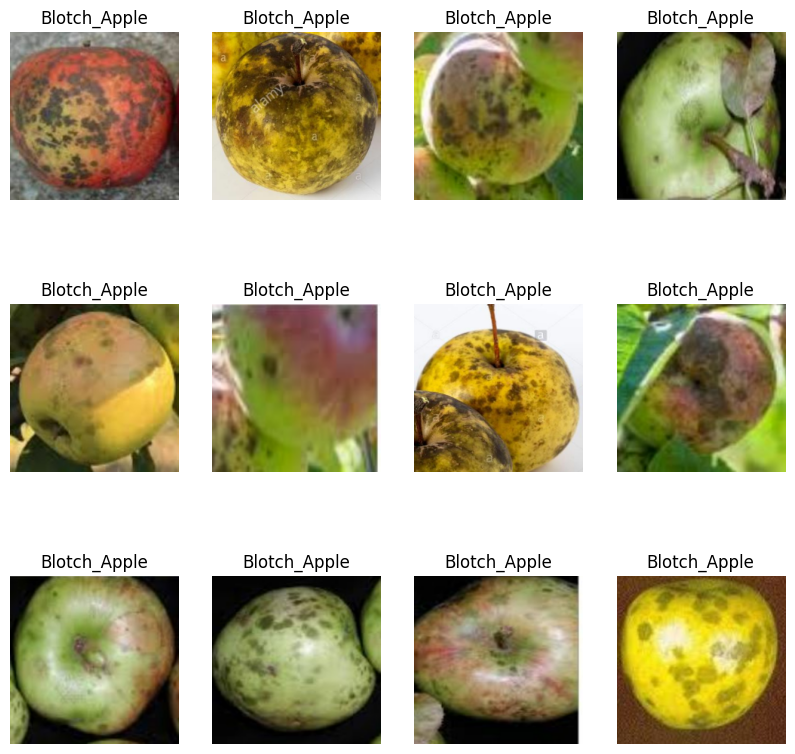

In [361]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [362]:
train_size = 0.8
len(dataset)*train_size

100.0

In [363]:
train_ds = dataset.take(9) # met .take() worden de eerste (x) batches geslecteerd
len(train_ds)

9

In [364]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
test_ds = testset
len(test_ds) # lengte in batches

4

In [365]:
val_size = 0.2
len(dataset)*val_size

25.0

In [366]:
val_ds = dataset.skip(9)
len(val_ds)

116

In [367]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [368]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [369]:
# len(train_ds)

In [370]:
# len(val_ds)

In [371]:
# len(test_ds)

In [372]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) ## bij CPU én GPU gebruik.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [373]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

In [374]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Apply data augmentation to train dataset

In [375]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [376]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [377]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    # tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),  
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')          
])

model.build(input_shape=input_shape)

In [378]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [379]:
# model.summary()

In [380]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [381]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [382]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/15
100/100 [==============================] - 30s 273ms/step - loss: 1.2751 - accuracy: 0.4019 - val_loss: 1.2412 - val_accuracy: 0.4112
Epoch 2/15
100/100 [==============================] - 22s 214ms/step - loss: 1.0548 - accuracy: 0.5650 - val_loss: 1.0759 - val_accuracy: 0.5475
Epoch 3/15
100/100 [==============================] - 20s 201ms/step - loss: 1.0004 - accuracy: 0.5859 - val_loss: 1.0758 - val_accuracy: 0.5300
Epoch 4/15
100/100 [==============================] - 23s 231ms/step - loss: 0.9616 - accuracy: 0.6019 - val_loss: 0.9388 - val_accuracy: 0.6325
Epoch 5/15
100/100 [==============================] - 24s 245ms/step - loss: 0.9211 - accuracy: 0.6197 - val_loss: 0.8830 - val_accuracy: 0.6400
Epoch 6/15
100/100 [==============================] - 23s 229ms/step - loss: 0.8823 - accuracy: 0.6316 - val_loss: 0.8389 - val_accuracy: 0.6675
Epoch 7/15
100/100 [==============================] - 23s 226ms/step - loss: 0.8354 - accuracy: 0.6572 - val_loss: 0.8399 - val_ac

In [383]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 0s 37ms/step - loss: 1.2045 - accuracy: 0.5083


In [384]:
# scores

In [385]:
# history

In [386]:
# history.params

In [387]:
# history.history.keys()

In [388]:
# len(history.history['accuracy'])

In [389]:
# type(history.history['loss'])
# len(history.history['loss'])

In [390]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [391]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

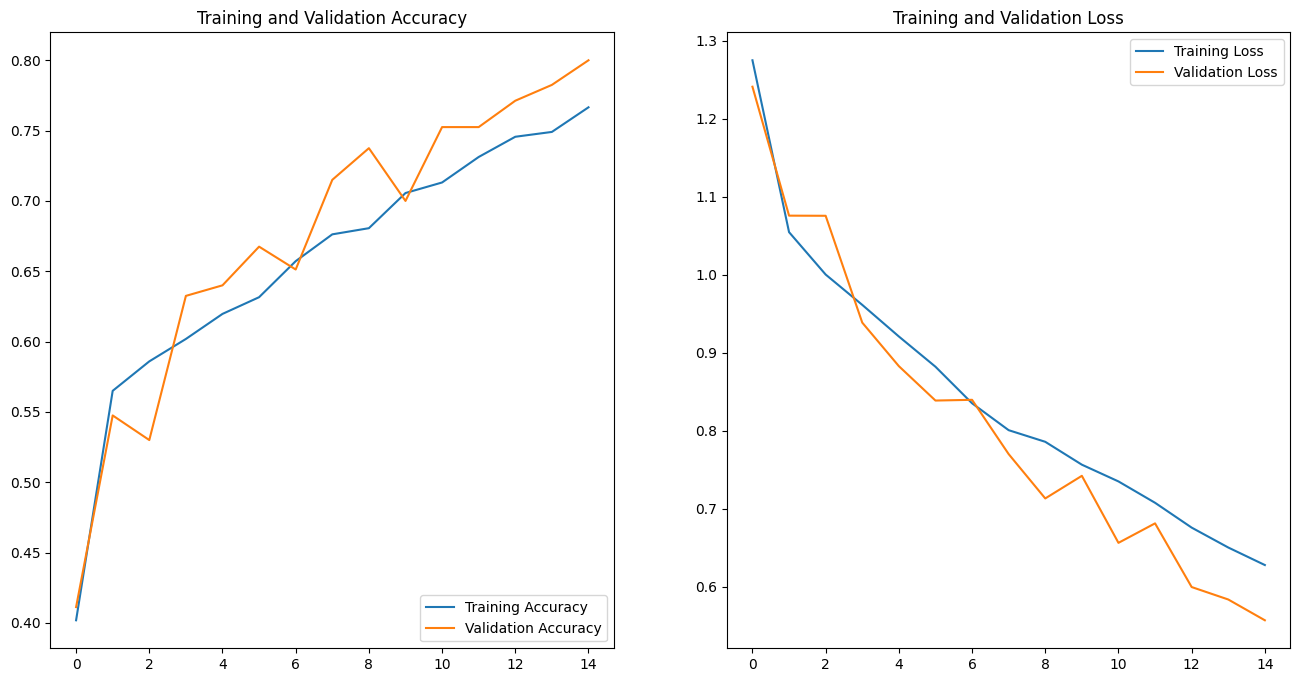

In [392]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image's actual label: Blotch_Apple
Predicted label: Scab_Apple


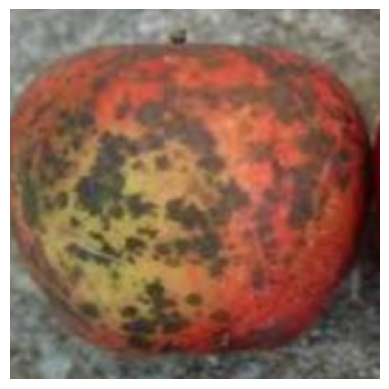

In [393]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

In [394]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
                                  

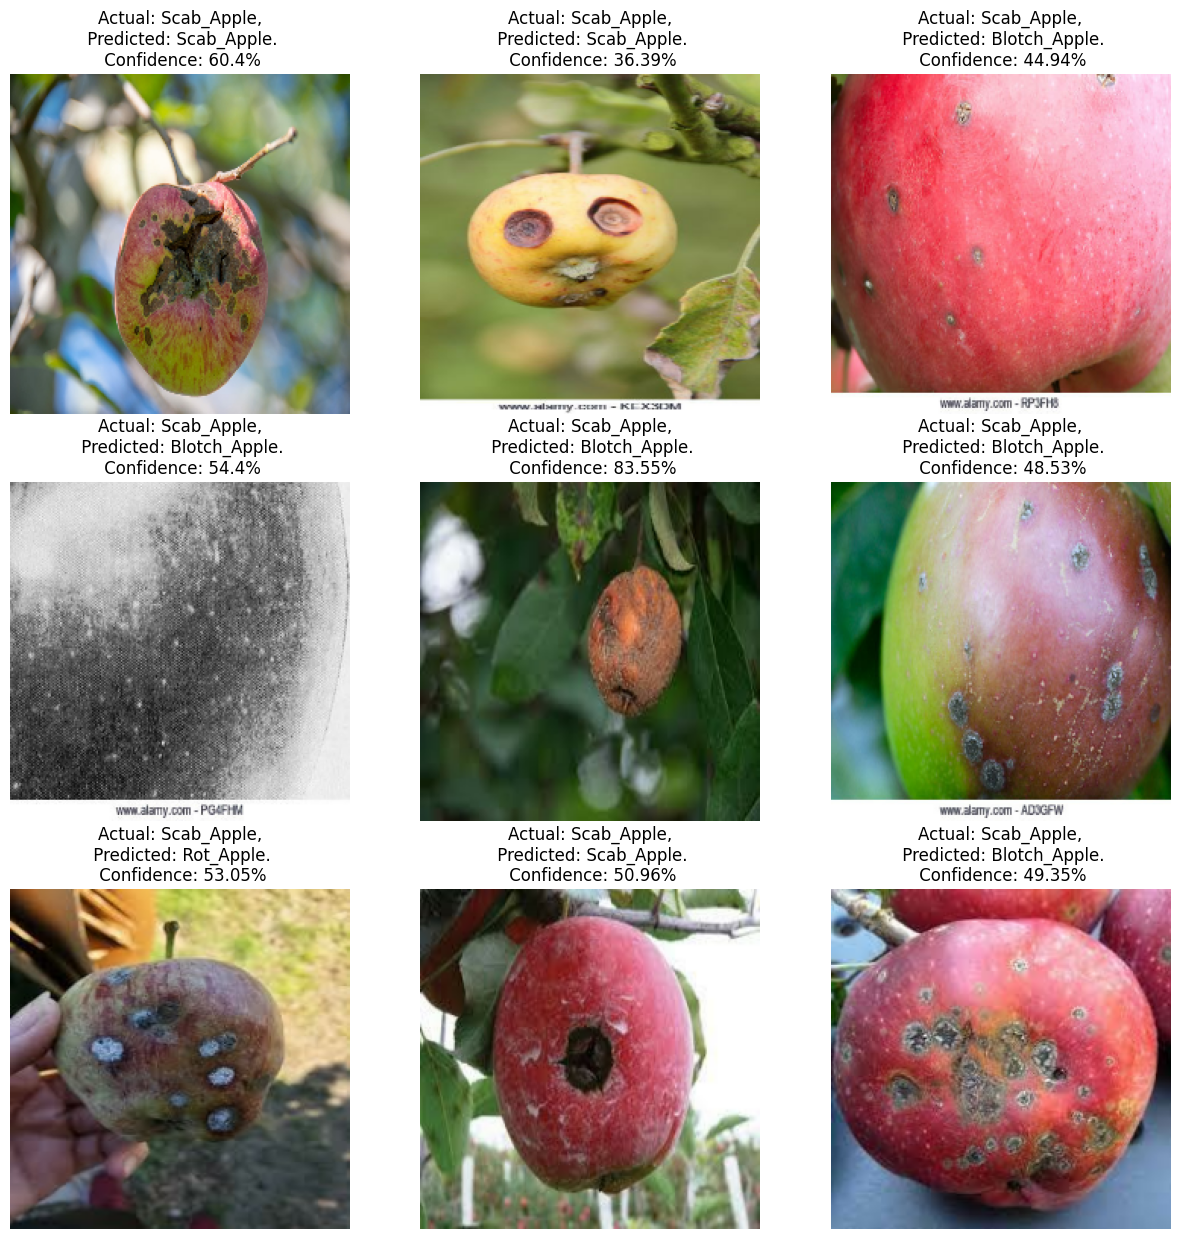

In [395]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [396]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}") # check ValueError: invalid literal for int() with base 10: '.gitkeep' <<<

INFO:tensorflow:Assets written to: ../models/23\assets


In [397]:
# model.save("..models/../apples.h5")

In [398]:
model.predict(test_ds)

array([[1.01195440e-01, 5.36875904e-01, 2.53417585e-02, 3.36586893e-01],
       [4.73986268e-02, 1.54944301e-01, 6.66567683e-01, 1.31089404e-01],
       [3.12547982e-02, 7.74148226e-01, 1.58183753e-01, 3.64133269e-02],
       [1.95536762e-03, 2.36083511e-02, 9.45120811e-01, 2.93154251e-02],
       [1.88373253e-02, 9.28786159e-01, 3.42283212e-02, 1.81481596e-02],
       [3.35588902e-02, 1.34897053e-01, 7.30193496e-01, 1.01350620e-01],
       [1.14817485e-05, 9.99762714e-01, 2.25473006e-04, 3.96771924e-07],
       [3.38499877e-03, 9.88575399e-01, 6.39771391e-03, 1.64178910e-03],
       [4.87624764e-01, 3.25526111e-02, 6.18926343e-03, 4.73633379e-01],
       [9.62246180e-01, 2.97917007e-03, 1.75316595e-02, 1.72429290e-02],
       [3.52569036e-02, 1.18757345e-01, 2.24372582e-03, 8.43742013e-01],
       [7.16487225e-03, 2.49276720e-02, 2.27490804e-04, 9.67680037e-01],
       [9.84990671e-02, 2.71733701e-01, 1.57164991e-01, 4.72602278e-01],
       [1.65865086e-02, 7.34124959e-01, 5.56512503e

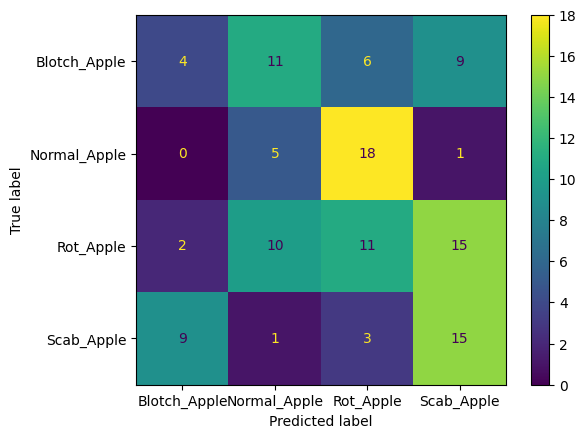

In [399]:
predictionBatch = model.predict(test_ds)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()

In [400]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16904), started 19:16:13 ago. (Use '!kill 16904' to kill it.)